# Проект: выбор оптимальной локации для бурения нефтескважины

# Описание проекта

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## План работы:

1. [Изучение данных. Подготовка данных к моделированию.](#start)

2. [Обучение и проверка модели для каждого региона](#train)

3. [Подготовка к расчету прибыли и составление функции расчета прибыли в регионе.](#profit)

4. [Расчет прибыли и рисков для каждого региона и обоснование выбора региона.](#calculation)

5. [Общий вывод.](#conclusion)


<a id="start"></a>
# 1. Загрузка и подготовка данных

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_0 = pd.read_csv('/datasets/geo_data_0.csv')
df_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [3]:
df_1 = pd.read_csv('/datasets/geo_data_1.csv')
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [4]:
df_2 = pd.read_csv('/datasets/geo_data_2.csv')
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Как видим, данные в порядке, пропуски отсутствуют, с типами данных тоже все в порядке.

Удалим из каждого датафрейма признак id, так как он не несет значимости для обучения модели.

In [5]:
df_0 = df_0.drop(['id'], axis=1)
df_1 = df_1.drop(['id'], axis=1)
df_2 = df_2.drop(['id'], axis=1)

Посмотрим количество нулевых значений в целевом признаке в каждом из регионов

In [6]:
def check_zeros(df, target_feature):
    zeros = df[df[target_feature] == 0][target_feature].count()
    percent = zeros / df.shape[0]
    print('Количество нулевых значений -', zeros)
    print('Удельный вес нулевых значений -', percent)

In [7]:
check_zeros(df_0, 'product')


Количество нулевых значений - 1
Удельный вес нулевых значений - 1e-05


In [8]:
check_zeros(df_1, 'product')


Количество нулевых значений - 8235
Удельный вес нулевых значений - 0.08235


In [9]:
check_zeros(df_2, 'product')


Количество нулевых значений - 1
Удельный вес нулевых значений - 1e-05


Визуально посмотрим на распределение значений по столбцу product

In [10]:
def oil_hist(seria, bins, xlim_max, ylim_max):
    plt.figure(figsize=[12,9])

    plt.hist(seria, bins=bins)

    plt.xlim([0,xlim_max])
    plt.ylim([0,ylim_max])

    plt.xlabel("Объем нефти на скважину, тыс. барелей")
    plt.ylabel("Количество скважин")

    plt.title("График распределения по объему скважин")
    plt.show()


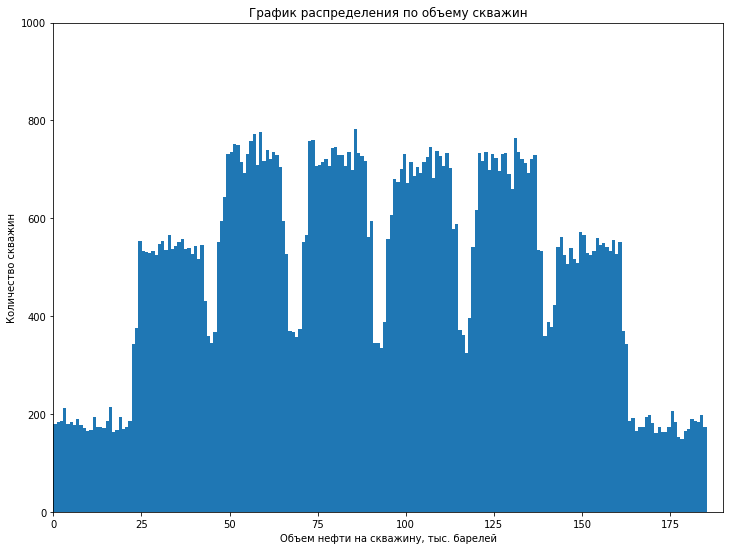

In [11]:
oil_hist(df_0['product'], 200, 190, 1000)

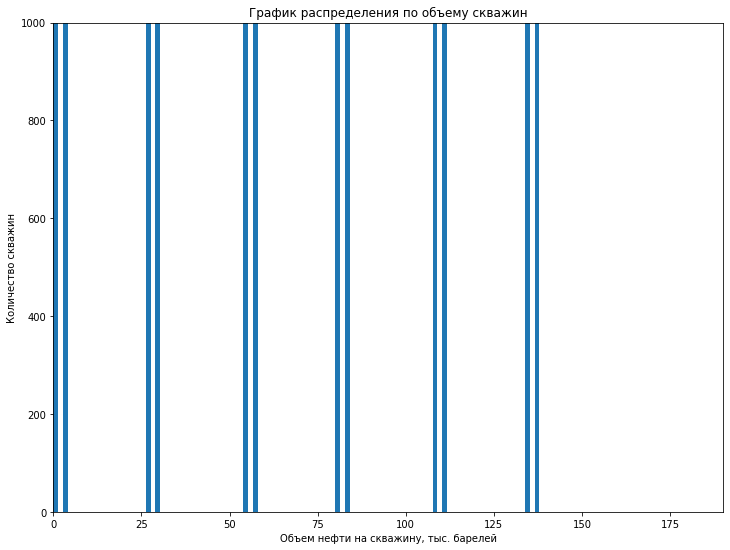

In [12]:
oil_hist(df_1['product'], 100, 190, 1000)

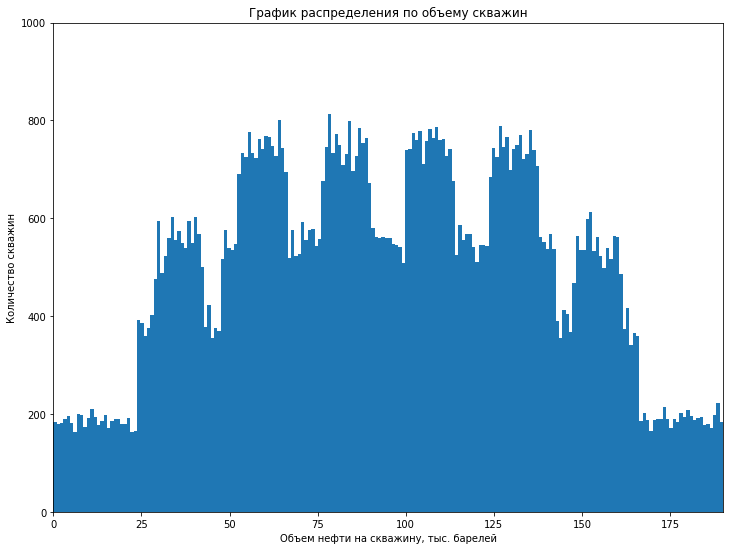

In [13]:
oil_hist(df_2['product'], 200, 190, 1000)

### Вывод

В ходе выполнения первого шага мы подготовили данные к обучению.

Мы будем анализировать 3 датафрейма (региона) со следующими признаками:

id — уникальный идентификатор скважины;

f0, f1, f2 — три признака точек;

product — объём запасов в скважине (тыс. баррелей).

Нами принято решение, удалить из каждого датафрейма признак id, так как он не несет значимости для обучения модели.

Пропусков значений и некорректных типов данных нами не обнаружено.

Вместе с тем, во втором регионе (df_1) около 8,2% месторождений не имело значения в столбце product. При сравнении с такими же значениями из первого и третьего региона можно сделать вывод, что возможно имела место утеря данных или объем запасов еще не был исследован.

Также, мы визуально посмотрели на распределение значений по столбцу product в каждом регионе.

На графиках мы увидели, что у первого и третьего региона распределение значений близкое к нормальному, при этом во втором регионе данные имеют странное распределение: от 0 до 5 тыс. баррелей с шагом по 15-20 тыс. равномерно распределены 1000 значений. Данные не подчиняются закону больших чисел и скорее всего введены искусcтвенно.

<a id="train"></a>

# 2. Обучение и проверка модели

Проверим качество модели линейной регрессии с текущими значениями признаков и с масштабированными. Проверим эту гипотезу на первом регионе (df_0).

In [14]:
def test_split(df, target):
    features = df.drop([target] , axis=1)
    target = df[target]

    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)
    
    return features_train, features_valid, target_train, target_valid

In [15]:
features_train_0, features_valid_0, target_train_0, target_valid_0 = test_split(df_0, 'product')

In [16]:
def test_split_scaled(df, numeric, target):
    df_s = df.copy()

    features_s = df_s.drop([target] , axis=1)
    target_s = df_s[target]

    features_train_s, features_valid_s, target_train_s, target_valid_s = train_test_split(
        features_s, target_s, test_size=0.25, random_state=12345)

    scaler = StandardScaler()
    scaler.fit(features_train_s[numeric])
    features_train_s[numeric] = scaler.transform(features_train_s[numeric])
    features_valid_s[numeric] = scaler.transform(features_valid_s[numeric])

    return features_train_s, features_valid_s, target_train_s, target_valid_s

Проведем обучение модели без измененных данных (немасштабированных).

In [17]:
model = LinearRegression()

model.fit(features_train_0, target_train_0)
predicted_target_0 = model.predict(features_valid_0)
print('RMSE -', mean_squared_error(target_valid_0, predicted_target_0)**0.5)

RMSE - 37.5794217150813


А теперь  проверим, каково значение RMSE на маштабированных данных

In [18]:
features_train_0s, features_valid_0s, target_train_0s, target_valid_0s = test_split_scaled(
                                                                        df_0, ['f0', 'f1', 'f2'], 'product')
model.fit(features_train_0s, target_train_0s)
predicted_target_0s = model.predict(features_valid_0s)
print('RMSE на масштабированных данных -', mean_squared_error(target_valid_0s, predicted_target_0s)**0.5)

RMSE на масштабированных данных - 37.5794217150813


Аналогичные расчеты произведем для других регионов

In [19]:
features_train_1, features_valid_1, target_train_1, target_valid_1 = test_split(df_1, 'product')
model.fit(features_train_1, target_train_1)
predicted_target_1 = model.predict(features_valid_1)
print('RMSE -', mean_squared_error(target_valid_1, predicted_target_1)**0.5)

features_train_1s, features_valid_1s, target_train_1s, target_valid_1s = test_split_scaled(
                                                                        df_1, ['f0', 'f1', 'f2'], 'product')
model.fit(features_train_1s, target_train_1s)
predicted_target_1s = model.predict(features_valid_1s)
print('RMSE на масштабированных данных -', mean_squared_error(target_valid_1s, predicted_target_1s)**0.5)

RMSE - 0.893099286775616
RMSE на масштабированных данных - 0.8930992867756158


In [20]:
features_train_2, features_valid_2, target_train_2, target_valid_2 = test_split(df_2, 'product')
model.fit(features_train_2, target_train_2)
predicted_target_2 = model.predict(features_valid_2)
print('RMSE -', mean_squared_error(target_valid_2, predicted_target_2)**0.5)

features_train_2s, features_valid_2s, target_train_2s, target_valid_2s = test_split_scaled(
                                                                        df_2, ['f0', 'f1', 'f2'], 'product')
model.fit(features_train_2s, target_train_2s)
predicted_target_2s = model.predict(features_valid_2s)
print('RMSE на масштабированных данных -', mean_squared_error(target_valid_2s, predicted_target_2s)**0.5)

RMSE - 40.02970873393434
RMSE на масштабированных данных - 40.02970873393434


Как видим, масштабирование данных не требуется.

Произведем вывод предсказанного запаса с реальным и выведем RMSE в разрезе каждого региона

In [21]:

def oil_predict(df, target_name):
    features = df.drop([target_name] , axis=1)
    target = df[target_name]
    
    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=5062020)
    
    model.fit(features_train, target_train)
    predicted_target = model.predict(features_valid)
    data = {'real_product' : target_valid,
            'predicted_product' : predicted_target         
    }
    data_frame = pd.DataFrame(data, columns = ['real_product', 'predicted_product'])
    rmse = mean_squared_error(target_valid, predicted_target)**0.5
    mean = data_frame['predicted_product'].mean()
    oil_sum = data_frame['predicted_product'].sum()
    return data_frame, rmse, mean, oil_sum

In [22]:
df_0_predicted, df_0_rmse, df_0_predicted_mean, df_0_predicted_sum = oil_predict(df_0, 'product')
print(df_0_predicted.head())
print('RMSE -', df_0_rmse)
print('Средний запас сырья, тыс. бареллей -', df_0_predicted_mean)

       real_product  predicted_product
87351    145.407098         110.644337
52805    131.589165          76.793446
6583     101.596316         103.711077
34986      8.123407          53.135348
8253     169.834019         151.656408
RMSE - 37.401957199217094
Средний запас сырья, тыс. бареллей - 92.52620585803335


In [23]:
df_1_predicted, df_1_rmse, df_1_predicted_mean,df_1_predicted_sum = oil_predict(df_1, 'product')
print(df_1_predicted.head())
print('RMSE -', df_1_rmse)
print('Средний запас сырья, тыс. бареллей -', df_1_predicted_mean)

       real_product  predicted_product
87351     53.906522          54.336477
52805      3.179103           3.756436
6583      30.132364          31.266991
34986     26.953261          26.692436
8253      30.132364          31.128898
RMSE - 0.8874258342572853
Средний запас сырья, тыс. бареллей - 68.27820207556354


In [24]:
df_2_predicted, df_2_rmse, df_2_predicted_mean, df_2_predicted_sum = oil_predict(df_2, 'product')
print(df_2_predicted.head())
print('RMSE -', df_2_rmse)
print('Средний запас сырья, тыс. бареллей -', df_2_predicted_mean)

       real_product  predicted_product
87351    140.971569          62.929196
52805    125.190694          98.323840
6583      94.544056          79.920918
34986    107.208380         104.706020
8253     173.924418         114.066050
RMSE - 40.18553497171235
Средний запас сырья, тыс. бареллей - 94.94294307153748


In [25]:
print('Суммарный предсказанный запас в позиции 0 -', df_0_predicted_sum)
print('Суммарный реальный запас в позиции 0 -', df_0_predicted['real_product'].sum())
print()
print('Суммарный предсказанный запас в позиции 1 -', df_1_predicted_sum)
print('Суммарный реальный запас в позиции 1 -', df_1_predicted['real_product'].sum())
print()
print('Суммарный предсказанный запас в позиции 2 -', df_2_predicted_sum)
print('Суммарный реальный запас в позиции 2 -', df_2_predicted['real_product'].sum())

Суммарный предсказанный запас в позиции 0 - 2313155.146450834
Суммарный реальный запас в позиции 0 - 2313395.805667925

Суммарный предсказанный запас в позиции 1 - 1706955.0518890887
Суммарный реальный запас в позиции 1 - 1706710.3444370048

Суммарный предсказанный запас в позиции 2 - 2373573.576788437
Суммарный реальный запас в позиции 2 - 2378821.7815969232


### Вывод

В ходе выполнения 2 шага мы проверили качество модели линейной регрессии с текущими значениями признаков и с масштабированными, разницы не увидели, поэтому масштабирование данных в рассматриваемой задаче не требуется.

После этого мы произвели вывод предсказанного запаса с реальным и вывели RMSE в разрезе каждого региона.

Суммарные значения предсказаний о количестве нефти  практически совпадают  с суммарными предсказанными значениями. 

Лучше всего модель предсказала запасы во втором регионе (RMSE - 0.88), далее в третьем и первом соотвественно, в частности остальные месторождения предсказаны с большой ошибкой.

Также можно заметить, что у месторождения (df_1), которое предсказано лучше всех, меньше всего среднего запаса сырья, чем у остальных  регионов. 

Возможно утеряные данные из второго региона сказались на модели и она переобучилась.

Можно сделать вывод, что из-за большой ошибки, значения среднего запаса могут быть другими. Попробуем применить технологию Bootstrap, чтобы получить нормальное распределение данных.

<a id="profit"></a>

# 3. Подготовка к расчёту прибыли

Создадим переменные об экономической информации.

In [26]:
budget = 1e+07 #Мы расчитываем прибыль в тысячах рублей за тысячу барелей, поэтому 1 милиард сохранен таким образом
chosen_points = 500 #количество исследуемых точек при разведке региона
best_points = 200 # количество лучших точек для разработки
income_per_barrel = 450 #доход с единицы продукта

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Сравним полученный объём сырья со средним запасом в каждом регионе.
Безубыточную разработку сырья будем рассчитывать на 200 месторождениях. 

In [27]:
min_profit_per_point = budget / best_points
print('Минимальная прибыль на лучшую точку -', min_profit_per_point, 'тыс.руб.')

min_barrels_per_point = min_profit_per_point  / income_per_barrel
print('Минимальный объем нефти на точку -',min_barrels_per_point, 'тыс. барелей')

min_barrels = budget / income_per_barrel
print('Минимальный объем нефти на регион -',min_barrels, 'тыс. барелей')

Минимальная прибыль на лучшую точку - 50000.0 тыс.руб.
Минимальный объем нефти на точку - 111.11111111111111 тыс. барелей
Минимальный объем нефти на регион - 22222.222222222223 тыс. барелей


In [28]:
print('Средний фактический запас нефти на скважину в регионе 1, тыс. бареллей', df_0['product'].mean())
print('Средний фактичесий запас нефти на скважину в регионе 2, тыс. бареллей', df_1['product'].mean())
print('Средний фактический запас нефти на скважину в регионе 3, тыс бареллей', df_2['product'].mean())

Средний фактический запас нефти на скважину в регионе 1, тыс. бареллей 92.50000000000001
Средний фактичесий запас нефти на скважину в регионе 2, тыс. бареллей 68.82500000000002
Средний фактический запас нефти на скважину в регионе 3, тыс бареллей 95.00000000000004


Создадим функцию для расчета приыли на 500 разведанных точках.

In [29]:
def oil_profit_calculation(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return income_per_barrel * selected.sum() - budget

Выведем распределение предсказанных значений.

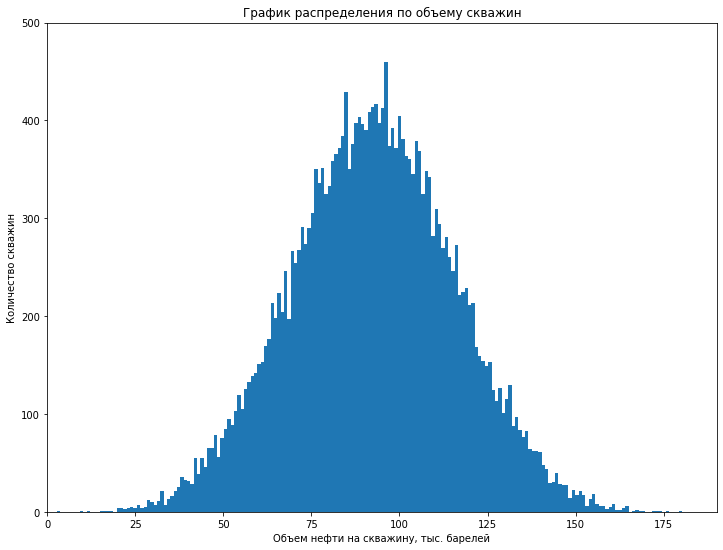

In [30]:
oil_hist(df_0_predicted['predicted_product'], 200, 190, 500)

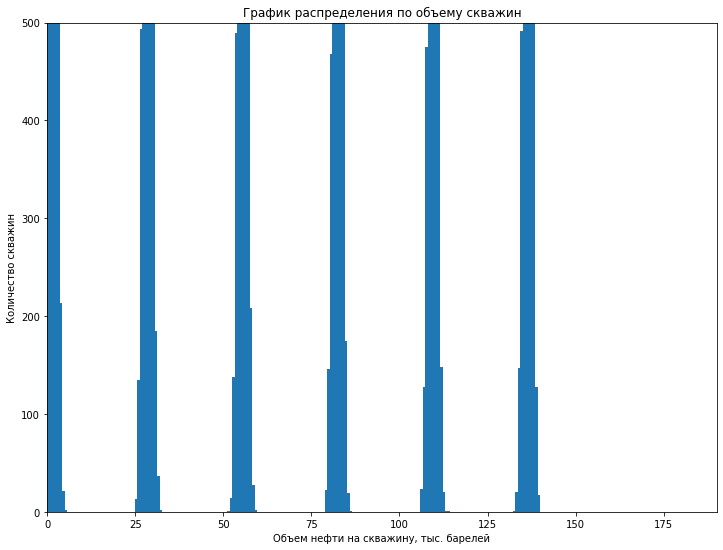

In [31]:
oil_hist(df_1_predicted['predicted_product'], 200, 190, 500)

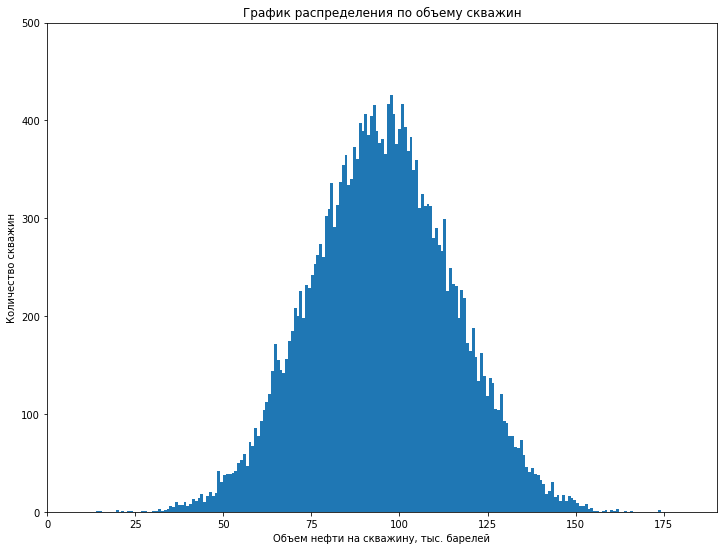

In [32]:
oil_hist(df_2_predicted['predicted_product'], 200, 190, 500)

### Вывод

В ходе выполнения 3 шага произведена оценка минимального размера прибыли на скважину и минимального объема запасов на скважину, а также создана функция по расчету прибыли.

Также мы сравнили полученный объём сырья со средним запасом в каждом регионе. Для первого и третьего - высокая вероятность окупить затраты. Разброс значений вокруг среднего 92.5 и 95 говорит нам о том, что существует достаточно много скважин, где запасы больше необходимого минимального запаса.

Во втором регионе (df_1) значений больше 111 достаточно много и при наличии большого везения можно выбрать только лучшие в этой выборке, хотя и среднее значение 68.8.

<a id="calculation"></a>

# 4. Расчёт прибыли и рисков 

Посчитаем риски и прибыль для каждого региона.  Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли

In [33]:
state = np.random.RandomState(12345)
def bootstrap_1000(target, probs):
    values=[]
    lost = 0
    for i in range(1000):
        target_sample = target.sample(replace=True, random_state=state, n=chosen_points)
        probs_sample = probs[target_sample.index]
        profit = oil_profit_calculation(target, probs_sample, best_points)
        if profit < 0:
            lost +=1
        values.append(profit)
    
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    average = values.mean()
    risk = lost / 1000
    return average, lower, upper, risk

Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков для каждого региона.

In [34]:
average_0, lower_0, upper_0, risk_0 = bootstrap_1000(df_0_predicted['real_product'], 
                                                     df_0_predicted['predicted_product'])
print('Данные по первому региону.')
print('Средняя прибыль по региону = {:.2f} тыс.руб.'.format(average_0))
print('95% доверительный интервал от {:.2f} до {:.2f} тыс.руб.'.format(lower_0, upper_0))
print('Процент риска {:.2%}'.format(risk_0))

Данные по первому региону.
Средняя прибыль по региону = 434350.79 тыс.руб.
95% доверительный интервал от -90159.97 до 932812.54 тыс.руб.
Процент риска 5.00%


In [35]:
average_1, lower_1, upper_1, risk_1 = bootstrap_1000(df_1_predicted['real_product'], 
                                                     df_1_predicted['predicted_product'])
print('Данные по второму региону.')
print('Средняя прибыль по региону = {:.2f} тыс.руб.'.format(average_1))
print('95% доверительный интервал от {:.2f} до {:.2f} тыс.руб.'.format(lower_1, upper_1))
print('Процент риска {:.2%}'.format(risk_1))

Данные по второму региону.
Средняя прибыль по региону = 432521.50 тыс.руб.
95% доверительный интервал от 44615.29 до 838081.46 тыс.руб.
Процент риска 1.90%


In [ ]:
average_2, lower_2, upper_2, risk_2 = bootstrap_1000(df_2_predicted['real_product'], 
                                                     df_2_predicted['predicted_product'])
print('Данные по третьему региону.')
print('Средняя прибыль по региону = {:.2f} тыс.руб.'.format(average_2))
print('95% доверительный интервал от {:.2f} до {:.2f} тыс.руб.'.format(lower_2, upper_2))
print('Процент риска {:.2%}'.format(risk_2))

### Вывод

В ходе выполнения 4 шага  мы посчитали риски и прибыль для каждого региона.  Применили технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли, а также нашли среднюю прибыль, 95%-й доверительный интервал и риск убытков для каждого региона.

В результате мы отсеиваем первый и третий регион, так как риски достаточно велики, то есть велика вероятность убытков. Остается один единственный регион - второй, где риск ниже требуемого. Кроме того, доверительный интервал по 2 региону показывает, что даже при не очень удачном выборе, разработка скважин окупится.

<a id="conclusion"></a>

# 5.Общий вывод

По результатам проведенного исследования можно сделать нижеследующие выводы.

 * В ходе выполнения первого шага мы подготовили данные к обучению.

Мы определили, что будем анализировать 3 датафрейма (региона) со следующими признаками:

id — уникальный идентификатор скважины;

f0, f1, f2 — три признака точек;

product — объём запасов в скважине (тыс. баррелей).

Нами принято решение, удалить из каждого датафрейма признак id, так как он не несет значимости для обучения модели.

Пропусков значений и некорректных типов данных нами не обнаружено.

Вместе с тем, во втором регионе (df_1) около 8,2% месторождений не имело значения в столбце product. При сравнении с такими же значениями из первого и третьего региона можно сделать вывод, что возможно имела место утеря данных или объем запасов еще не был исследован.

Также, мы визуально посмотрели на распределение значений по столбцу product в каждом регионе.

На графиках мы увидели, что у первого и третьего региона распределение значений близкое к нормальному, при этом во втором регионе данные имеют странное распределение: от 0 до 5 тыс. баррелей с шагом по 15-20 тыс. равномерно распределены 1000 значений. Данные не подчиняются закону больших чисел и скорее всего введены искусcтвенно.

 * В ходе выполнения 2 шага мы проверили качество модели линейной регрессии с текущими значениями признаков и с масштабированными, разницы не увидели, поэтому масштабирование данных в рассматриваемой задаче не требуется.

После этого мы произвели вывод предсказанного запаса с реальным и вывели RMSE в разрезе каждого региона.

Нами устаовлено, что суммарные значения предсказаний о количестве нефти  практически совпадают  с суммарными предсказанными значениями. 

Лучше всего модель предсказала запасы во втором регионе (RMSE - 0.88), далее в третьем и первом соотвественно, в частности остальные месторождения предсказаны с большой ошибкой.

Также нами замечено, что у месторождения (df_1), которое предсказано лучше всех, меньше всего среднего запаса сырья, чем у остальных  регионов. 

Возможно утеряные данные из второго региона сказались на модели и она переобучилась.

Мы сделали вывод, что из-за большой ошибки, значения среднего запаса могут быть другими. 

 * В ходе выполнения 3 шага произведена оценка минимального размера прибыли на скважину и минимального объема запасов на скважину, а также создана функция по расчету прибыли.

Также мы сравнили полученный объём сырья со средним запасом в каждом регионе. Для первого и третьего - высокая вероятность окупить затраты. Разброс значений вокруг среднего 92.5 и 95 говорит нам о том, что существует достаточно много скважин, где запасы больше необходимого минимального запаса.

Мы увидели, что во втором регионе (df_1) значений больше 111 достаточно много и при наличии большого везения можно выбрать только лучшие в этой выборке, хотя и среднее значение 68,8.

 * В ходе выполнения 4 шага мы посчитали риски и прибыль для каждого региона. Применили технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли, а также нашли среднюю прибыль, 95%-й доверительный интервал и риск убытков для каждого региона.

В результате мы приняли решение, отсеять первый и третий регион, так как риски в данных регионах достаточно велики, то есть велика вероятность убытков. Остается один единственный регион - второй, где риск ниже требуемого. Кроме того, доверительный интервал по 2 региону показывает, что даже при не очень удачном выборе, разработка скважин окупится.

Учитывая вышеизложенное, наиболее оптимальной локацией в данном случае является второй регион (df_1).